**NOTE:** This Jupyter notebook is derived from the Jupyter notebook located at https://github.com/ageron/handson-ml as of 01/06/2019, as discussed in Hands-On Machine Learning. It is used here for educational purposes only.

**Chapter 8 – Dimensionality Reduction**


# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "../.."
CHAPTER_ID = "unsupervised_learning"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    try:
        plt.savefig(path, format='png', dpi=300)
    except:
        plt.savefig(fig_id + ".png", format='png', dpi=300)

# Projection methods
Build 3D dataset:

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

## PCA using SVD decomposition

Note: the `svd()` function returns `U`, `s` and `Vt`, where `Vt` is equal to $\mathbf{V}^T$, the transpose of the matrix $\mathbf{V}$. Earlier versions of the book mistakenly said that it returned `V` instead of `Vt`. Also, Equation 8-1 should actually contain $\mathbf{V}$ instead of $\mathbf{V}^T$, like this:

$
\mathbf{V} =
\begin{pmatrix}
  \mid & \mid & & \mid \\
  \mathbf{c_1} & \mathbf{c_2} & \cdots & \mathbf{c_n} \\
  \mid & \mid & & \mid
\end{pmatrix}
$

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

## PCA using Scikit-Learn

With Scikit-Learn, PCA is really trivial. It even takes care of mean centering for you:

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [9]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [10]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

Notice that running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped. In this example, PCA using Scikit-Learn gives the same projection as the one given by the SVD approach, except both axes are flipped:

In [11]:
np.allclose(X2D, -X2D_using_svd)

True

Recover the 3D points projected on the plane (PCA 2D subspace).

In [12]:
X3D_inv = pca.inverse_transform(X2D)

Of course, there was some loss of information during the projection step, so the recovered 3D points are not exactly equal to the original 3D points:

In [13]:
np.allclose(X3D_inv, X)

False

We can compute the reconstruction error:

In [14]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

The inverse transform in the SVD approach looks like this:

In [15]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

The reconstructions from both methods are not identical because Scikit-Learn's `PCA` class automatically takes care of reversing the mean centering, but if we subtract the mean, we get the same reconstruction:

In [16]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

The `PCA` object gives access to the principal components that it computed:

In [17]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

Compare to the first two principal components computed using the SVD method:

In [18]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

Notice how the axes are flipped.

Now let's look at the explained variance ratio:

In [19]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

The first dimension explains 84.2% of the variance, while the second explains 14.6%.

By projecting down to 2D, we lost about 1.1% of the variance:

In [20]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

Here is how to compute the explained variance ratio using the SVD approach (recall that `s` is the diagonal of the matrix `S`):

In [21]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

Next, let's generate some nice figures! :)

Utility class to draw 3D arrows (copied from http://stackoverflow.com/questions/11140163)

In [22]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

Express the plane as a function of x and y.

In [23]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

Plot the 3D dataset, the plane and the projections on that plane.

Saving figure dataset_3d_plot


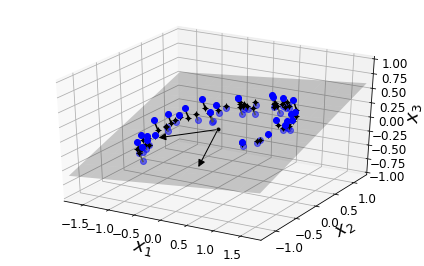

In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

save_fig("dataset_3d_plot")
plt.show()

Saving figure dataset_2d_plot


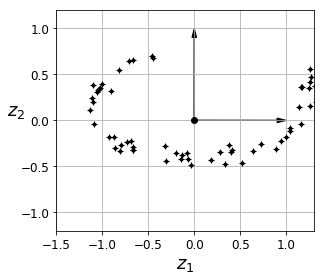

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
save_fig("dataset_2d_plot")

# PCA

Saving figure pca_best_projection


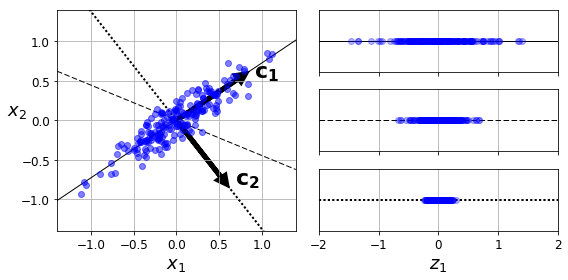

In [26]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("pca_best_projection")
plt.show()

# PCA for Portfolio Optimisation

In [43]:
from matplotlib import style
import seaborn as sns
from scipy.stats import randint as sp_randint
from sklearn.decomposition import PCA
from pathlib import Path
import pandas as pd
style.use("ggplot")

# loading the data

github_p = "https://github.com/Finance-781/FinML/blob/master/Lecture%207%20-%20Principal%20Components/Inclass/data"

my_file = Path("data/Dow_adjcloses.csv") # Defines path
if my_file.is_file():              # See if file exists
    print("Local file found")      
    df = pd.read_csv('data/Dow_adjcloses.csv', parse_dates=True, index_col=0)
else:
    print("Be patient: loading from github (2 minutes)")
    df = pd.read_csv(github_p+'data/Dow_adjcloses.csv', parse_dates=True, index_col=0)
    print("Done")
df.head()

Local file found


MMM        AXP      AAPL         BA        CAT        CVX  \
Date                                                                          
2000-01-03  29.847043  35.476634  3.530576  26.650218  14.560887  21.582046   
2000-01-04  28.661131  34.134275  3.232839  26.610431  14.372251  21.582046   
2000-01-05  30.122175  33.959430  3.280149  28.473758  14.914205  22.049145   
2000-01-06  31.877325  33.959430  2.996290  28.553331  15.459153  22.903343   
2000-01-07  32.509812  34.433913  3.138219  29.382213  15.962182  23.305926   

                 CSCO         KO        DIS  DWDP    ...           NKE  \
Date                                                 ...                 
2000-01-03  43.003876  16.983583  23.522220   NaN    ...      4.701180   
2000-01-04  40.577200  17.040950  24.899860   NaN    ...      4.445214   
2000-01-05  40.895453  17.228147  25.781550   NaN    ...      4.702157   
2000-01-06  39.781569  17.210031  24.899860   NaN    ...      4.677733   
2000-01-07  42.128682  18.342270  24.506249   NaN    ...      4.677733   

                  PFE         PG        TRV        UTX       UNH         VZ  \
Date                                                                          
2000-01-03  16.746856  32.227726  20.158885  21.319030  5.841355  22.564221   
2000-01-04  16.121738  31.596399  19.890099  20.445803  5.766368  21.833915   
2000-01-05  16.415912  31.325831  20.085579  20.254784  5.753327  22.564221   
2000-01-06  16.972739  32.438168  20.122232  20.998392  5.964159  22.449405   
2000-01-07  18.123166  35.023602  20.922479  21.830687  6.662948  22.282692   

             V        WMT        WBA  
Date                                  
2000-01-03 NaN  47.337599  21.713237  
2000-01-04 NaN  45.566248  20.907354  
2000-01-05 NaN  44.503437  21.097421  
2000-01-06 NaN  45.126952  20.527220  
2000-01-07 NaN  48.535033  21.051805  

[5 rows x 30 columns]

In [44]:
# Dropping 'Not a Number' columns for Dow Chemicals (DWDP) and Visa (V)
df.drop(['DWDP', 'V'], axis=1, inplace=True)
# Copying the dataframe to add features
data = pd.DataFrame(df.copy())
# Daily Returns
# Daily Log Returns (%)
# datareturns = np.log(data / data.shift(1)) 

# Daily Linear Returns (%)
datareturns = data.pct_change(1)

# Dow Jones Equal Weighted rETURN
datareturns["DJIA"] = datareturns.mean(axis=1)

# Data Raw
data_raw = datareturns
data_raw.dropna(how='all', inplace=True)

# Normalizing the returns
data = (data_raw - data_raw.mean()) / data_raw.std()

# Getting rid of the NaN values.
data.dropna(how='any', inplace=True)
data_raw.dropna(how='any', inplace=True)


In [45]:
data.head()

MMM       AXP      AAPL        BA       CAT       CVX  \
Date                                                                     
2000-01-04 -2.783305 -1.714531 -3.315064 -0.118649 -0.672149 -0.030177   
2000-01-05  3.491453 -0.250475  0.522450  3.667073  1.828679  1.321853   
2000-01-06  3.995818 -0.021248 -3.400666  0.108313  1.770951  2.389941   
2000-01-07  1.337698  0.604016  1.791770  1.497066  1.573522  1.067883   
2000-01-10 -0.371257  0.624764 -0.727008 -0.780316 -1.653060 -1.711071   

                CSCO        KO       DIS       XOM    ...          NKE  \
Date                                                  ...                
2000-01-04 -2.304726  0.236964  3.089027 -1.283097    ...    -2.927985   
2000-01-05  0.305449  0.823741  1.857074  3.247575    ...     3.023666   
2000-01-06 -1.119210 -0.104682 -1.845881  3.696220    ...    -0.316511   
2000-01-07  2.382987  5.050971 -0.867545 -0.216324    ...    -0.041103   
2000-01-10  1.482524 -2.486755  8.090552 -0.944732    ...     0.855881   

                 PFE        PG       TRV       UTX       UNH        VZ  \
Date                                                                     
2000-01-04 -2.410473 -1.504783 -0.763609 -2.479568 -0.698935 -2.097284   
2000-01-05  1.148279 -0.671468  0.510782 -0.588825 -0.164440  2.128033   
2000-01-06  2.151911  2.659281  0.070428  2.165327  1.801922 -0.346058   
2000-01-07  4.320217  5.999317  2.158221  2.340150  5.871398 -0.496143   
2000-01-10 -0.131547 -0.413525 -1.026003  0.558540 -0.923939 -0.357794   

                 WMT       WBA      DJIA  
Date                                      
2000-01-04 -2.506437 -2.167895 -2.739489  
2000-01-05 -1.568817  0.502376  1.631646  
2000-01-06  0.914757 -1.584911  0.181378  
2000-01-07  5.006585  1.453883  3.054606  
2000-01-10 -1.231132  1.667529  0.250687  

[5 rows x 29 columns]

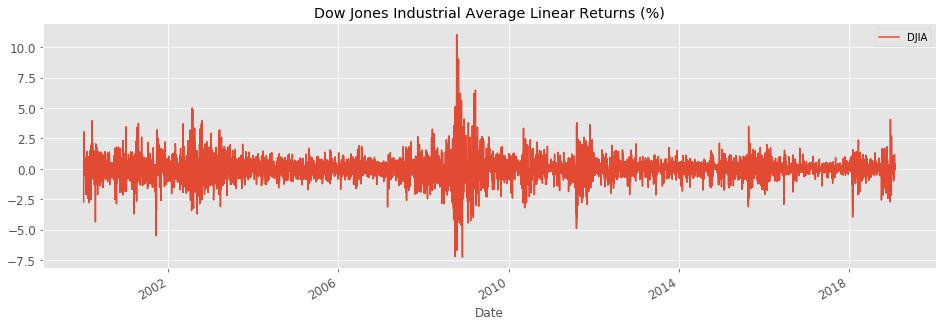

In [46]:
# Visualizing Log Returns for the DJIA a

plt.figure(figsize=(16, 5))
plt.title("Dow Jones Industrial Average Linear Returns (%)")
data.DJIA.plot()
plt.grid(True);
plt.legend()
plt.show()

In [47]:
# Taking away the market benchmark DJIA
stock_tickers = data.columns.values[:-1]
n_tickers = len(stock_tickers)

# Dividing the dataset into training and testing sets
percentage = int(len(data) * 0.8)
X_train = data[:percentage]
X_test = data[percentage:]

X_train_raw = data_raw[:percentage]
X_test_raw = data_raw[percentage:]

# Applying Principle Component Analysis
# Creating covariance matrix and training data on PCA.
cov_matrix = X_train.loc[:,X_train.columns != 'DJIA'].cov()
pca = PCA()
pca.fit(cov_matrix)



PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

21 principal components explain 95.00% of variance


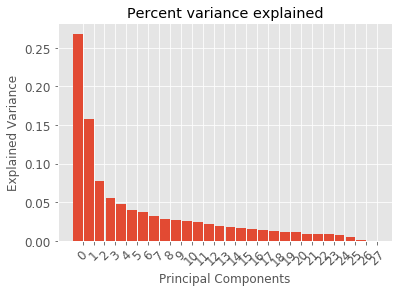

In [48]:
def plotPCA(plot=False):

    # Visualizing Variance against number of principal components.
    cov_matrix_raw = X_train_raw.loc[:,X_train_raw.columns != 'DJIA'].cov()

    var_threshold = 0.95
    var_explained = np.cumsum(pca.explained_variance_ratio_)
    num_comp = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1  

    if plot:
        print('%d principal components explain %.2f%% of variance' %(num_comp, 100* var_threshold))

        # PCA percent variance explained.
        bar_width = 0.9
        n_asset = stock_tickers.shape[0]
        x_indx = np.arange(n_asset)
        fig, ax = plt.subplots()

        # Eigenvalues measured as percentage of explained variance.
        rects = ax.bar(x_indx, pca.explained_variance_ratio_[:n_asset], bar_width)
        ax.set_xticks(x_indx + bar_width / 2)
        ax.set_xticklabels(list(range(n_asset)), rotation=45)
        ax.set_title('Percent variance explained')
        ax.set_ylabel('Explained Variance')
        ax.set_xlabel('Principal Components')
        plt.show()

plotPCA(plot=True)

In [49]:
projected = pca.fit_transform(cov_matrix)
pcs = pca.components_

In [50]:
# Sharpe Ratio
def sharpe_ratio(ts_returns, periods_per_year=252):
    '''
    Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.
    It calculares the annualized return, annualized volatility, and annualized sharpe ratio.
    
    ts_returns are  returns of a signle eigen portfolio.
    '''
    n_years = ts_returns.shape[0]/periods_per_year
    annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in power


Eigen portfolio #24 with the highest Sharpe. Return nan%, vol = 349.81%, Sharpe = nan
      Return       Vol    Sharpe
18  0.653514  0.520659  1.255167
22  0.520714  0.598663  0.869794
4   0.523931  0.634943  0.825162
9   0.434588  0.571939  0.759850
15  0.557383  0.806050  0.691499
0   0.472930  0.687234  0.688165
7   0.552926  1.220988  0.452852
26  0.190378  0.565123  0.336878
13  0.201774  0.750856  0.268725
5   0.033209  0.951549  0.034900


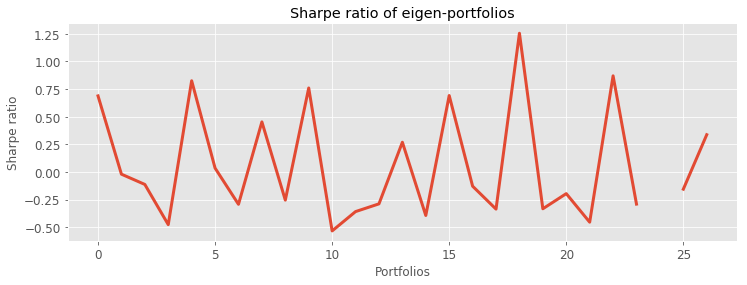

In [51]:
def optimizedPortfolio():
    n_portfolios = len(pcs)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0 

    for i in range(n_portfolios):
        
        pc_w = pcs[:, i] / sum(pcs[:, i])
        eigen_prtfi = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
        eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)
        
        eigen_prti_returns = np.dot(X_test_raw.loc[:, eigen_prtfi.index], eigen_prtfi / n_portfolios)
        eigen_prti_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_test.index)
        er, vol, sharpe = sharpe_ratio(eigen_prti_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe

    # find portfolio with the highest Sharpe ratio
    highest_sharpe = np.argmax(sharpe_metric)

    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100, 
           annualized_vol[highest_sharpe]*100, 
           sharpe_metric[highest_sharpe]))


    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

    results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
    results.dropna(inplace=True)
    results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
    print(results.head(10))

    plt.show()

optimizedPortfolio()

Sum of weights of current eigen-portfolio: 100.00


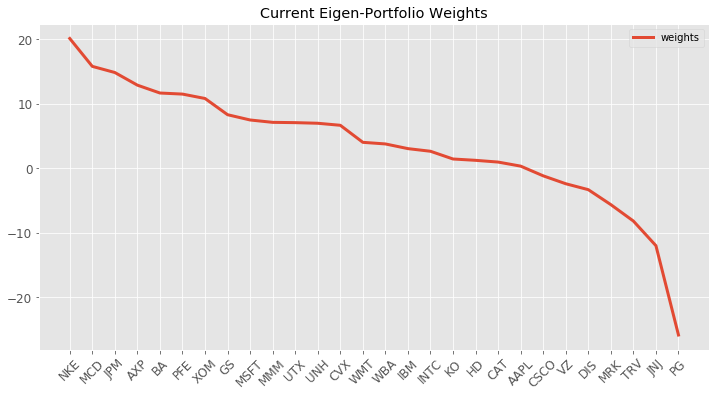

weights
NKE   20.117567
MCD   15.796158
JPM   14.842129
AXP   12.882346
BA    11.663451
PFE   11.497129
XOM   10.814829
GS     8.299560
MSFT   7.481802
MMM    7.115468
UTX    7.070083
UNH    6.974290
CVX    6.659061
WMT    4.018289
WBA    3.767133
IBM    3.040566
INTC   2.631129
KO     1.432335
HD     1.226338
CAT    0.956180
AAPL   0.326093
CSCO  -1.178381
VZ    -2.403519
DIS   -3.323544
MRK   -5.645020
TRV   -8.190654
JNJ  -12.011671
PG   -25.859148

In [52]:
def PCWeights():
    '''
    Principal Components (PC) weights for each 28 PCs
    '''
    weights = pd.DataFrame()

    for i in range(len(pcs)):
        weights["weights_{}".format(i)] = pcs[:, i] / sum(pcs[:, i])

    weights = weights.values.T
    return weights

weights = PCWeights()
portfolio = portfolio = pd.DataFrame()

def plotEigen(weights, plot=False, portfolio=portfolio):
    portfolio = pd.DataFrame(data ={'weights': weights.squeeze()*100}, index = stock_tickers) 
    portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
    
    if plot:
        print('Sum of weights of current eigen-portfolio: %.2f' % np.sum(portfolio))
        portfolio.plot(title='Current Eigen-Portfolio Weights', 
            figsize=(12,6), 
            xticks=range(0, len(stock_tickers),1), 
            rot=45, 
            linewidth=3
            )
        plt.show()

    return portfolio

# Weights are stored in arrays, where 0 is the first PC's weights.
plotEigen(weights=weights[4], plot=True)

Current Eigen-Portfolio:
Return = 52.39%
Volatility = 63.49%
Sharpe = 0.83


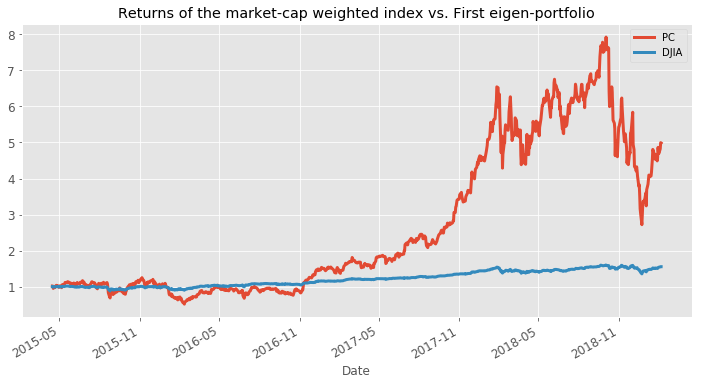

In [53]:
def plotSharpe(eigen):

    '''

    Plots Principle components returns against real returns.
    
    '''

    eigen_portfolio_returns = np.dot(X_test_raw.loc[:, eigen.index], eigen / len(pcs))
    eigen_portfolio_returns = pd.Series(eigen_portfolio_returns.squeeze(), index=X_test.index)
    returns, vol, sharpe = sharpe_ratio(eigen_portfolio_returns)
    print('Current Eigen-Portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (returns*100, vol*100, sharpe))
    year_frac = (eigen_portfolio_returns.index[-1] - eigen_portfolio_returns.index[0]).days / 252

    df_plot = pd.DataFrame({'PC': eigen_portfolio_returns, 'DJIA': X_test_raw.loc[:, 'DJIA']}, index=X_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First eigen-portfolio', 
                             figsize=(12,6), linewidth=3)
    plt.show()

plotSharpe(eigen=plotEigen(weights=weights[4]))